<a href="https://colab.research.google.com/github/Alf-caput/NFL2022_TacklePredictNN/blob/dev1/PracticaFinal_TacklingNFL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import gdown
import os
id = '1V_fIjH-WGHTVgyRkdNFkZ6XxiqDoaMrA'
folder = 'nfl-big-data-bowl-2024'
endpoint = '.zip'

url = f'https://drive.google.com/uc?id={id}'

output = folder + endpoint

if not os.path.exists(output):
    gdown.download(url, output, quiet=False)

In [3]:
from zipfile import ZipFile

if not os.path.exists(folder):
	with ZipFile(output, 'r') as zObject:
		zObject.extractall(folder)

In [4]:
import pandas as pd
import os

csv_files = [file for file in os.listdir(folder) if file.endswith('.csv')]
csv_files.sort()

In [ ]:
print(csv_files)

['games.csv', 'players.csv', 'plays.csv', 'tackles.csv', 'tracking_week_1.csv', 'tracking_week_2.csv', 'tracking_week_3.csv', 'tracking_week_4.csv', 'tracking_week_5.csv', 'tracking_week_6.csv', 'tracking_week_7.csv', 'tracking_week_8.csv', 'tracking_week_9.csv']


Dentro de la carpeta nfl-big-data-bowl-2024 se encuentran los csv que utilizaremos, a continuación creamos un diccionario para facilitarnos el acceso a los diferentes dataframes (dfs).

In [5]:
dfs = {os.path.splitext(file)[0]: pd.read_csv(os.path.join(folder, file)) for file in csv_files}

In [ ]:
dfs.keys()

dict_keys(['games', 'players', 'plays', 'tackles', 'tracking_week_1', 'tracking_week_2', 'tracking_week_3', 'tracking_week_4', 'tracking_week_5', 'tracking_week_6', 'tracking_week_7', 'tracking_week_8', 'tracking_week_9'])

In [ ]:
df_week1 = dfs['tracking_week_1']

game_ids = df_week1['gameId'].unique()
df_week1_game1 = df_week1[df_week1['gameId']==game_ids[0]]

play_ids = df_week1_game1['playId'].unique()
df_week1_game1_play1 = df_week1_game1[df_week1_game1['playId']==play_ids[0]]

frame_ids = df_week1_game1_play1['frameId'].unique()
df_week1_game1_play1_frame1 = df_week1_game1_play1[df_week1_game1_play1['frameId']==frame_ids[0]]

df_week1_game1_play1_frame1.head(3)

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event
0,2022090800,56,35472.0,Rodger Saffold,1,2022-09-08 20:24:05.200000,76.0,BUF,left,88.37,27.27,1.62,1.15,0.16,231.74,147.90,NaN
22,2022090800,56,38577.0,Bobby Wagner,1,2022-09-08 20:24:05.200000,45.0,LA,left,78.25,27.53,1.24,3.81,0.11,4.20,331.67,NaN
44,2022090800,56,41239.0,Aaron Donald,1,2022-09-08 20:24:05.200000,99.0,LA,left,91.08,31.61,3.91,2.34,0.40,168.33,132.02,NaN


In [ ]:
df_week1_game1_play1_frame1.drop(columns=['displayName', 'jerseyNumber'], inplace=True)
df_week1_game1_play1_frame1.head(3)

C:\Users\alfre\AppData\Local\Temp\ipykernel_19984\3667134759.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_week1_game1_play1_frame1.drop(columns=['displayName', 'jerseyNumber'], inplace=True)


,gameId,playId,nflId,frameId,time,club,playDirection,x,y,s,a,dis,o,dir,event
0,2022090800,56,35472.0,1,2022-09-08 20:24:05.200000,BUF,left,88.37,27.27,1.62,1.15,0.16,231.74,147.90,NaN
22,2022090800,56,38577.0,1,2022-09-08 20:24:05.200000,LA,left,78.25,27.53,1.24,3.81,0.11,4.20,331.67,NaN
44,2022090800,56,41239.0,1,2022-09-08 20:24:05.200000,LA,left,91.08,31.61,3.91,2.34,0.40,168.33,132.02,NaN


In [ ]:
df_week1_game1_play1_frame1 = pd.merge(df_week1_game1_play1_frame1, dfs['players'][['position', 'nflId']], on='nflId', how='left')
df_week1_game1_play1_frame1.head(3)

,gameId,playId,nflId,frameId,time,club,playDirection,x,y,s,a,dis,o,dir,event,position
0,2022090800,56,35472.0,1,2022-09-08 20:24:05.200000,BUF,left,88.37,27.27,1.62,1.15,0.16,231.74,147.90,NaN,G
1,2022090800,56,38577.0,1,2022-09-08 20:24:05.200000,LA,left,78.25,27.53,1.24,3.81,0.11,4.20,331.67,NaN,ILB
2,2022090800,56,41239.0,1,2022-09-08 20:24:05.200000,LA,left,91.08,31.61,3.91,2.34,0.40,168.33,132.02,NaN,DT


In [ ]:
df_week1_game1_play1_frame1 = pd.merge(df_week1_game1_play1_frame1, dfs['games'][['homeTeamAbbr', 'gameId']], on='gameId', how='left')
df_week1_game1_play1_frame1.head(3)

,gameId,playId,nflId,frameId,time,club,playDirection,x,y,s,a,dis,o,dir,event,position,homeTeamAbbr
0,2022090800,56,35472.0,1,2022-09-08 20:24:05.200000,BUF,left,88.37,27.27,1.62,1.15,0.16,231.74,147.90,NaN,G,LA
1,2022090800,56,38577.0,1,2022-09-08 20:24:05.200000,LA,left,78.25,27.53,1.24,3.81,0.11,4.20,331.67,NaN,ILB,LA
2,2022090800,56,41239.0,1,2022-09-08 20:24:05.200000,LA,left,91.08,31.61,3.91,2.34,0.40,168.33,132.02,NaN,DT,LA


Como ahora sabemos el equipo local en la columna club cambiamos las abreviaturas a valor 0 (visitante) ó 1 (local) ó -1 (football)

In [ ]:
df_week1_game1_play1_frame1['homeTeamAbbr'].unique()[0]

'LA'

In [ ]:
local = df_week1_game1_play1_frame1['homeTeamAbbr'].unique()[0]
df_week1_game1_play1_frame1.loc[df_week1_game1_play1_frame1['club'] == 'football', 'club'] = -1
df_week1_game1_play1_frame1.loc[df_week1_game1_play1_frame1['club'] == local, 'club'] = 1
df_week1_game1_play1_frame1.loc[(df_week1_game1_play1_frame1['club'] != -1) & (df_week1_game1_play1_frame1['club'] != 1), 'club'] = 0
df_week1_game1_play1_frame1.head(3)

,gameId,playId,nflId,frameId,time,club,playDirection,x,y,s,a,dis,o,dir,event,position,homeTeamAbbr
0,2022090800,56,35472.0,1,2022-09-08 20:24:05.200000,0,left,88.37,27.27,1.62,1.15,0.16,231.74,147.90,NaN,G,LA
1,2022090800,56,38577.0,1,2022-09-08 20:24:05.200000,1,left,78.25,27.53,1.24,3.81,0.11,4.20,331.67,NaN,ILB,LA
2,2022090800,56,41239.0,1,2022-09-08 20:24:05.200000,1,left,91.08,31.61,3.91,2.34,0.40,168.33,132.02,NaN,DT,LA


Si ataca el equipo local playDirection = 1, en caso contrario (ataca equipo visitante) playDirection = 0

In [ ]:
df_week1_game1_play1_frame1.loc[:, 'playDirection'] = int(df_week1_game1_play1_frame1['playDirection'].unique()[0] == 'right')
df_week1_game1_play1_frame1.head(3)

,gameId,playId,nflId,frameId,time,club,playDirection,x,y,s,a,dis,o,dir,event,position,homeTeamAbbr
0,2022090800,56,35472.0,1,2022-09-08 20:24:05.200000,0,0,88.37,27.27,1.62,1.15,0.16,231.74,147.90,NaN,G,LA
1,2022090800,56,38577.0,1,2022-09-08 20:24:05.200000,1,0,78.25,27.53,1.24,3.81,0.11,4.20,331.67,NaN,ILB,LA
2,2022090800,56,41239.0,1,2022-09-08 20:24:05.200000,1,0,91.08,31.61,3.91,2.34,0.40,168.33,132.02,NaN,DT,LA


Sustituimos el tiempo por el cuarto de juego en el que se encuentran y añadimos columnas con el intento (down) y el número de yardas restantes (yardsToGo)

In [ ]:
df_week1_game1_play1_frame1 = pd.merge(df_week1_game1_play1_frame1, dfs['plays'][['down', 'quarter', 'yardsToGo', 'gameId', 'playId']], on=['gameId', 'playId'], how='left')
df_week1_game1_play1_frame1.drop(columns='time')
df_week1_game1_play1_frame1.head(3)

,gameId,playId,nflId,frameId,time,club,playDirection,x,y,s,a,dis,o,dir,event,position,homeTeamAbbr,down,quarter,yardsToGo
0,2022090800,56,35472.0,1,2022-09-08 20:24:05.200000,0,0,88.37,27.27,1.62,1.15,0.16,231.74,147.90,NaN,G,LA,1,1,10
1,2022090800,56,38577.0,1,2022-09-08 20:24:05.200000,1,0,78.25,27.53,1.24,3.81,0.11,4.20,331.67,NaN,ILB,LA,1,1,10
2,2022090800,56,41239.0,1,2022-09-08 20:24:05.200000,1,0,91.08,31.61,3.91,2.34,0.40,168.33,132.02,NaN,DT,LA,1,1,10


Ordenamos los jugadores por equipo

In [ ]:
df_week1_game1_play1_frame1 = df_week1_game1_play1_frame1.sort_values(by='club', ascending=True)
df_week1_game1_play1_frame1.head(3)

,gameId,playId,nflId,frameId,time,club,playDirection,x,y,s,a,dis,o,dir,event,position,homeTeamAbbr,down,quarter,yardsToGo
22,2022090800,56,NaN,1,2022-09-08 20:24:05.200000,-1,0,85.050003,33.810001,22.209999,11.85,2.07,NaN,NaN,NaN,NaN,LA,1,1,10
20,2022090800,56,53522.0,1,2022-09-08 20:24:05.200000,0,0,91.960000,33.010000,2.400000,2.57,0.24,23.25,117.85,NaN,T,LA,1,1,10
18,2022090800,56,52536.0,1,2022-09-08 20:24:05.200000,0,0,74.350000,7.140000,7.910000,0.79,0.79,269.06,260.37,NaN,WR,LA,1,1,10


Eliminamos la columna de equipo local, obteniendo los datos finales para un frame que utilizaremos

In [ ]:
df_week1_game1_play1_frame1 = df_week1_game1_play1_frame1.drop(columns='homeTeamAbbr')
df_week1_game1_play1_frame1

,gameId,playId,nflId,frameId,time,club,playDirection,x,y,s,a,dis,o,dir,event,position,down,quarter,yardsToGo
22,2022090800,56,NaN,1,2022-09-08 20:24:05.200000,-1,0,85.050003,33.810001,22.209999,11.85,2.07,NaN,NaN,NaN,NaN,1,1,10
20,2022090800,56,53522.0,1,2022-09-08 20:24:05.200000,0,0,91.960000,33.010000,2.400000,2.57,0.24,23.25,117.85,NaN,T,1,1,10
18,2022090800,56,52536.0,1,2022-09-08 20:24:05.200000,0,0,74.350000,7.140000,7.910000,0.79,0.79,269.06,260.37,NaN,WR,1,1,10
17,2022090800,56,48512.0,1,2022-09-08 20:24:05.200000,0,0,90.220000,32.080000,2.770000,2.46,0.28,103.24,115.97,NaN,C,1,1,10
14,2022090800,56,47879.0,1,2022-09-08 20:24:05.200000,0,0,76.540000,32.030000,6.100000,4.49,0.61,155.02,220.71,NaN,TE,1,1,10
13,2022090800,56,47857.0,1,2022-09-08 20:24:05.200000,0,0,88.170000,24.170000,1.940000,0.33,0.19,325.95,238.13,NaN,RB,1,1,10
10,2022090800,56,44985.0,1,2022-09-08 20:24:05.200000,0,0,76.700000,18.390000,4.790000,6.34,0.49,157.83,233.63,NaN,WR,1,1,10
9,2022090800,56,44875.0,1,2022-09-08 20:24:05.200000,0,0,89.420000,25.810000,1.890000,2.47,0.18,242.67,65.25,NaN,T,1,1,10
0,2022090800,56,35472.0,1,2022-09-08 20:24:05.200000,0,0,88.370000,27.270000,1.620000,1.15,0.16,231.74,147.90,NaN,G,1,1,10
4,2022090800,56,42489.0,1,2022-09-08 20:24:05.200000,0,0,80.600000,38.290000,6.230000,0.90,0.62,140.05,189.38,NaN,WR,1,1,10


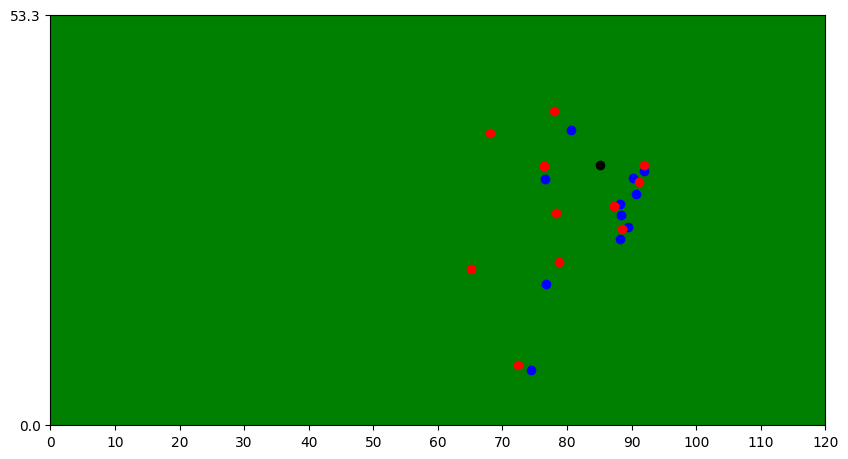

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5.33))

for i, row in df_week1_game1_play1_frame1.iterrows():
    if row['club'] == 0:
        color = 'blue'
    elif row['club'] == 1:
        color = 'red'
    else:
        color = 'black'
    ax.scatter(row['x'], row['y'], marker='o', color=color)
plt.xticks(range(0, 130, 10))
plt.yticks([0, 53.3])
ax.set_facecolor('green')

plt.show()


In [6]:
ds = pd.concat([dfs[f'tracking_week_{i}'] for i in range(1, 10)])
ds.drop(columns=['displayName', 'jerseyNumber', 'event', 'time', 'o', 'dir'], inplace=True)
ds

,gameId,playId,nflId,frameId,club,playDirection,x,y,s,a,dis
0,2022090800,56,35472.0,1,BUF,left,88.370000,27.270000,1.62,1.15,0.16
1,2022090800,56,35472.0,2,BUF,left,88.470000,27.130000,1.67,0.61,0.17
2,2022090800,56,35472.0,3,BUF,left,88.560000,27.010000,1.57,0.49,0.15
3,2022090800,56,35472.0,4,BUF,left,88.640000,26.900000,1.44,0.89,0.14
4,2022090800,56,35472.0,5,BUF,left,88.720000,26.800000,1.29,1.24,0.13
...,...,...,...,...,...,...,...,...,...,...,...
1150018,2022110700,3787,NaN,40,football,right,26.219999,19.680000,1.37,2.58,0.15
1150019,2022110700,3787,NaN,41,football,right,26.320000,19.610001,1.07,2.74,0.12
1150020,2022110700,3787,NaN,42,football,right,26.389999,19.559999,0.80,2.49,0.09
1150021,2022110700,3787,NaN,43,football,right,26.450001,19.520000,0.57,2.38,0.07


In [7]:
import numpy as np
ds_conteo = ds.groupby(['gameId', 'playId', 'frameId']).size().reset_index(name='Conteo')
print(f'Array con número de agentes por frame encontrados {np.unique(ds_conteo["Conteo"])}')
ds = pd.merge(ds, ds_conteo, on=['gameId', 'playId', 'frameId'], how='left')
ds = ds.loc[ds['Conteo'] != 1]
ds_conteo = ds.groupby(['gameId', 'playId', 'frameId']).size().reset_index(name='Conteo')
print('Limpieza de frames con nº agentes distinto a 23 (22 jugadores + 1 balón)')
print(f'Array con número de agentes por frame encontrados {np.unique(ds_conteo["Conteo"])}')
ds.drop(columns='Conteo', inplace=True)
ds

Array con número de agentes por frame encontrados [ 1 23]
Limpieza de frames con nº agentes distinto a 23 (22 jugadores + 1 balón)
Array con número de agentes por frame encontrados [23]


,gameId,playId,nflId,frameId,club,playDirection,x,y,s,a,dis
0,2022090800,56,35472.0,1,BUF,left,88.370000,27.270000,1.62,1.15,0.16
1,2022090800,56,35472.0,2,BUF,left,88.470000,27.130000,1.67,0.61,0.17
2,2022090800,56,35472.0,3,BUF,left,88.560000,27.010000,1.57,0.49,0.15
3,2022090800,56,35472.0,4,BUF,left,88.640000,26.900000,1.44,0.89,0.14
4,2022090800,56,35472.0,5,BUF,left,88.720000,26.800000,1.29,1.24,0.13
...,...,...,...,...,...,...,...,...,...,...,...
12187393,2022110700,3787,NaN,40,football,right,26.219999,19.680000,1.37,2.58,0.15
12187394,2022110700,3787,NaN,41,football,right,26.320000,19.610001,1.07,2.74,0.12
12187395,2022110700,3787,NaN,42,football,right,26.389999,19.559999,0.80,2.49,0.09
12187396,2022110700,3787,NaN,43,football,right,26.450001,19.520000,0.57,2.38,0.07


In [8]:
ds['playDirection'] = ds['playDirection'].replace({'left': -1, 'right': 1})


In [9]:
ds = pd.merge(ds, dfs['games'][['homeTeamAbbr', 'gameId']], on='gameId', how='left')
ds['local'] = -1
ds.loc[ds['club'] == ds['homeTeamAbbr'], 'local'] = 1
ds.loc[ds['club'] == 'football', 'local'] = 0
ds.drop(columns=['club', 'homeTeamAbbr'], inplace=True)


In [10]:
ds = pd.merge(ds, dfs['plays'][['ballCarrierId', 'playId', 'gameId']], on=['playId', 'gameId'], how='left')
ds['ballCarrier'] = 0
ds.loc[ds['nflId'] == ds['ballCarrierId'], 'ballCarrier'] = 1
ds.drop(columns='ballCarrierId', inplace=True)


In [11]:
ds.sort_values(by=['gameId', 'playId', 'frameId', 'local'], ascending=True, inplace=True)
# Como el orden de local es ascendente los 11 jugadores de las primeras 11 filas se corresponden con visitantes
# Haciendo innecesario el uso de la columna local
ds.reset_index(drop=True, inplace=True)


# Normalización de las columnas

In [24]:
ds

,gameId,playId,nflId,frameId,playDirection,x,y,s,a,dis,local,ballCarrier
0,2022090800,56,35472.0,1,-1,0.726583,0.561759,0.044505,0.019955,0.015595,-1,0
1,2022090800,56,42392.0,1,-1,0.725634,0.581346,0.018407,0.034184,0.006823,-1,0
2,2022090800,56,42489.0,1,-1,0.665165,0.708594,0.171154,0.015617,0.060429,-1,1
3,2022090800,56,44875.0,1,-1,0.734883,0.542305,0.051923,0.042860,0.017544,-1,0
4,2022090800,56,44985.0,1,-1,0.634337,0.443438,0.131593,0.110012,0.047758,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
12187212,2022110700,3787,52666.0,44,1,0.227571,0.477682,0.040110,0.023772,0.014620,1,0
12187213,2022110700,3787,52942.0,44,1,0.186230,0.528581,0.019505,0.012841,0.006823,1,0
12187214,2022110700,3787,53098.0,44,1,0.275630,0.676616,0.132692,0.043901,0.047758,1,0
12187215,2022110700,3787,54476.0,44,1,0.260058,0.328448,0.008242,0.017526,0.003899,1,0


In [12]:
columnas = ['x','y','s','a','dis']
for columna in columnas:
  media = ds[columna].mean()
  dt = ds[columna].std()

  ds[columna] = (ds[columna] - media) / dt

In [14]:
ds.to_csv('ds.csv', index=False)

KeyboardInterrupt: 

In [13]:
import tensorflow as tf
numeric_feature_names = ['playDirection', 'x', 'y', 's', 'a', 'dis']
numeric_features = ds[numeric_feature_names]
numeric_features.head()
snapshots = tf.convert_to_tensor(numeric_features)
snapshots = tf.reshape(snapshots, (-1, 23, 6))

target = 'ballCarrier'
label_features = ds[target]
labels = tf.convert_to_tensor(label_features)
labels = tf.reshape(labels, (-1, 23))
snapshots.shape, labels.shape

(TensorShape([529879, 23, 6]), TensorShape([529879, 23]))

El tercer elemento de x

In [47]:
snapshots[0,2,1]

<tf.Tensor: shape=(), dtype=float64, numpy=80.6>

# Datos de entrenamiento

In [14]:
ds_nfl =  tf.data.Dataset.from_tensor_slices((snapshots, labels))
ds_nfl

<_TensorSliceDataset element_spec=(TensorSpec(shape=(23, 6), dtype=tf.float64, name=None), TensorSpec(shape=(23,), dtype=tf.int64, name=None))>

In [15]:
for elem in ds_nfl.take(1):
  print(elem)

(<tf.Tensor: shape=(23, 6), dtype=float64, numpy=
array([[-1.        ,  1.13686793,  0.04231124, -0.5350988 , -0.47521691,
        -0.55269306],
       [-1.        ,  1.13198816,  0.19824225, -0.99236731,  0.11948948,
        -0.97590217],
       [-1.        ,  0.82090283,  1.21126349,  1.68385681, -0.65652983,
         1.61037573],
       [-1.        ,  1.17956592, -0.11255903, -0.40513828,  0.48211532,
        -0.45864659],
       [-1.        ,  0.66231031, -0.8996394 ,  0.99073402,  3.28883937,
         0.99907368],
       [-1.        ,  1.23365003,  0.33295817, -1.17527472, -0.58400466,
        -1.1639951 ],
       [-1.        ,  1.12873498, -0.28652288, -0.38107151, -1.0699233 ,
        -0.41162335],
       [-1.        ,  0.65580395,  0.54723072,  1.62128323,  1.94712374,
         1.56335249],
       [-1.        ,  1.21209771,  0.5525345 ,  0.01843676,  0.47486281,
         0.01158576],
       [-1.        ,  0.56674815, -2.09298902,  2.49250008, -0.73630752,
         2.40977071],


Tomamos datos de test.

In [16]:
num_train = len(ds_nfl)

RATIO = 0.2
test_size = int(RATIO * num_train)

ds_train = ds_nfl.skip(test_size)
ds_test = ds_nfl.take(test_size)

Y datos de validacion

In [17]:
num_train = len(ds_train)

RATIO = 0.2
validation_size = int(RATIO * num_train)

ds_fit = ds_nfl.skip(validation_size)
ds_val = ds_nfl.take(validation_size)

In [18]:
# Supongamos que tienes un conjunto de datos ds_fit y ds_val
# Asegúrate de configurar el tamaño del lote al crear los conjuntos de datos
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 1024
ds_fit = (
    ds_fit
    .cache()
    .shuffle(len(ds_fit))
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

ds_val = (
    ds_val
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

# Arquitectura de la red

In [19]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Definir la arquitectura de la red convolucional
model = models.Sequential()

model.add(layers.Input(shape=(23,6)))

# Agregar capa de zeropadding
model.add(layers.ZeroPadding1D(padding=1))

# Capa de convolución 1D
model.add(layers.Conv1D(64, kernel_size=3, activation='relu'))
# model.add(layers.MaxPooling1D(pool_size=2))

# Capa de aplanado para conectar con una capa densa
model.add(layers.Flatten())

# Capa densa
model.add(layers.Dense(128, activation='relu'))

# Capa de salida
model.add(layers.Dense(23, activation='softmax'))  # Suponiendo que estás realizando una tarea de clasificación 23

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Resumen de la arquitectura del modelo
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding1d (ZeroPaddin  (None, 25, 6)             0         
 g1D)                                                            
                                                                 
 conv1d (Conv1D)             (None, 23, 64)            1216      
                                                                 
 flatten (Flatten)           (None, 1472)              0         
                                                                 
 dense (Dense)               (None, 128)               188544    
                                                                 
 dense_1 (Dense)             (None, 23)                2967      
                                                                 
Total params: 192727 (752.84 KB)
Trainable params: 192727 (752.84 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [20]:
# Entrenamiento del modelo
history = model.fit(ds_fit, epochs=15, validation_data=ds_val)

Epoch 1/15
435/435 [==============================] - 9s 8ms/step - loss: 1.9382 - accuracy: 0.3911 - val_loss: 1.9147 - val_accuracy: 0.3653
Epoch 2/15
435/435 [==============================] - 3s 5ms/step - loss: 1.2881 - accuracy: 0.5782 - val_loss: 1.8416 - val_accuracy: 0.4107
Epoch 3/15
435/435 [==============================] - 3s 6ms/step - loss: 0.9616 - accuracy: 0.6879 - val_loss: 1.8495 - val_accuracy: 0.4325
Epoch 4/15
435/435 [==============================] - 3s 5ms/step - loss: 0.7357 - accuracy: 0.7633 - val_loss: 1.9272 - val_accuracy: 0.4519
Epoch 5/15
435/435 [==============================] - 3s 5ms/step - loss: 0.5755 - accuracy: 0.8157 - val_loss: 2.0101 - val_accuracy: 0.4632
Epoch 6/15
435/435 [==============================] - 3s 7ms/step - loss: 0.4603 - accuracy: 0.8541 - val_loss: 2.1408 - val_accuracy: 0.4640
Epoch 7/15
435/435 [==============================] - 3s 5ms/step - loss: 0.3748 - accuracy: 0.8825 - val_loss: 2.2450 - val_accuracy: 0.4702
Epoch 

In [21]:
BATCH_SIZE = 128
ds_eval = (
    ds_test.cache()
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)
test_loss, test_acc = model.evaluate(ds_eval)

print('Test accuracy:', test_acc)

828/828 [==============================] - 6s 5ms/step - loss: 2.8759 - accuracy: 0.5656
Test accuracy: 0.5655767917633057
